In [0]:
! wget 'https://github.com/adobe-research/deft_corpus/archive/master.zip'
! unzip master.zip
! mkdir trainingFiles
! mkdir testingFiles

In [0]:
! ls

In [0]:
! python3 deft_corpus-master/task1_converter.py deft_corpus-master/data/deft_files/train trainingFiles
! python3 deft_corpus-master/task1_converter.py deft_corpus-master/data/deft_files/dev testingFiles

In [0]:
# testing...
! head trainingFiles/task_1_t1_biology_0_0.deft

In [0]:
%load_ext cython
import os
import io
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
import nltk
import re
from nltk.stem import WordNetLemmatizer
import time
import multiprocessing
from gensim.models import word2vec
from bs4 import BeautifulSoup
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt; 
plt.rcdefaults()

import statistics

In [0]:
lemmatizer = WordNetLemmatizer()
stops = set(stopwords.words('english'))

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

def text_processing(text):
    text = text.lower() 
    
    #Split into individual words on whitespace and remove punctuation
    words = tokenizer.tokenize(text)
    # words = words.split()
    
    words = [lemmatizer.lemmatize(w) for w in words]   
    
    return ' '.join(words)

In [0]:
def readFiles(directoryName, process):
    tempDataFrames = []
    for root, dirs, files in os.walk(directoryName):
        for name in files:
            path = os.path.join(root, name)
            
            # Data is a panda dataframe
            data = pd.read_csv(path, sep="\t")
            data.columns = ["text", "classifier"]
            if process:
                data["text"] = data["text"].apply(text_processing)

            tempDataFrames.append(data)
    return pd.concat(tempDataFrames, axis=0, ignore_index=False)

In [0]:
trainingFrame = readFiles("trainingFiles", False)
testingFrame = readFiles("testingFiles", False)
trainingFrame.head()

In [0]:
# trainingFrame, validationFrame = train_test_split(trainingFrame, test_size=0.1)

In [0]:
trainingFrame.reset_index(inplace=True)
trainingFrame.sort_index(inplace=True)

testingFrame.reset_index(inplace=True)
testingFrame.sort_index(inplace=True)

# validationFrame.reset_index(inplace=True)
# validationFrame.sort_index(inplace=True)

In [0]:
trainingFrame

In [0]:
len(testingFrame)

In [0]:
print(len(trainingFrame[trainingFrame.classifier==0]))
print(len(trainingFrame[trainingFrame.classifier==1]))
print(len(testingFrame[testingFrame.classifier==0]))
print(len(testingFrame[testingFrame.classifier==1]))

In [0]:
trainingFrame_classifiers = trainingFrame["classifier"]
trainingFrame_text = trainingFrame["text"]

testingFrame_classifiers = testingFrame["classifier"]
testingFrame_text = testingFrame["text"]

testingFrame_classifiers = testingFrame_classifiers.to_numpy('int')
trainingFrame_classifiers = trainingFrame_classifiers.to_numpy('int')

In [0]:
# max_features = 30000
cvnoignore = CountVectorizer(analyzer='word')
#cvnoignore=CountVectorizer(min_df=1,stop_words='english', analyzer='word')
cvignore = TfidfVectorizer(min_df=1,stop_words='english', analyzer='word')
#cvignore=TfidfVectorizer()

In [0]:
training_cvnoignore=cvnoignore.fit_transform(trainingFrame_text)
training_cvignore=cvignore.fit_transform(trainingFrame_text)

In [0]:
mnbnoignore=MultinomialNB()
mnbignore=MultinomialNB()

In [0]:
mnbnoignore.fit(training_cvnoignore,trainingFrame_classifiers)
mnbignore.fit(training_cvignore,trainingFrame_classifiers)
testing_cvnoignore=cvnoignore.transform(testingFrame_text)
testing_cvignore=cvignore.transform(testingFrame_text)

prednoignore=mnbnoignore.predict(testing_cvnoignore)
predignore=mnbignore.predict(testing_cvignore)
print(accuracy_score(testingFrame_classifiers, prednoignore))
print(f1_score(testingFrame_classifiers,prednoignore,average='macro'))
print(f1_score(testingFrame_classifiers,predignore,average='macro'))
print(f1_score(testingFrame_classifiers,prednoignore,average='micro'))
print(f1_score(testingFrame_classifiers,predignore,average='micro'))
print(f1_score(testingFrame_classifiers,prednoignore,average='binary'))
print(f1_score(testingFrame_classifiers,predignore,average='binary'))
print(f1_score(testingFrame_classifiers,prednoignore,pos_label=1))
print(f1_score(testingFrame_classifiers,predignore,pos_label=1))

In [0]:
print (len(prednoignore))
a=training_cvignore.toarray()
print(len(a[0]))
b=training_cvnoignore.toarray()
print(len(b[0]))

In [0]:
sentences = [sent.split() for sent in trainingFrame_text]

In [0]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

num_features = 300    # Word vector dimensionality                      
min_word_count = 1   # Minimum word count                        
cores = multiprocessing.cpu_count()       # Number of threads to run in parallel
context = 5         # Context window size                                                                                    

model = word2vec.Word2Vec(sentences, workers=cores - 1, \
            size=num_features, min_count = min_word_count, \
            window = context, iter=6)

model.train(sentences=sentences, total_examples=len(sentences), epochs=10)

model.init_sims(replace=True)

In [0]:
model.wv.vectors.shape

In [0]:
numWords = 0
sentenceSize = []
def getVecForSent(sent, vocab_set):
    global numWords, sentenceSize
    vec = np.zeros(num_features, dtype="float32")
    num_words_in_sent = 0
    # sent = sent.split(' ')
    newsent = sent.split(' ')
    for word in newsent:
        if word in vocab_set:
            vec = np.add(vec, model[word])
            num_words_in_sent += 1

    
    numWords += num_words_in_sent
    sentenceSize.append(num_words_in_sent)

    if num_words_in_sent == 0:
        return vec
    
    vec = np.divide(vec, num_words_in_sent)
    return vec

def getAverageFeatureVectors(df):
    global numWords, sentenceSize
    vocab_set = set(model.wv.index2word)
    numWords = 0
    sentenceSize = []
    
    featureVecs = np.zeros((len(df), num_features),dtype="float32")

    for i, sent in enumerate(df):
        vec = getVecForSent(sent, vocab_set)
        featureVecs[i] = vec

    print('\n\n*********************************************')
    print('Average word size of sentence ', numWords // len(df))
    print('Standard deviation : ' , statistics.stdev(sentenceSize))
    print('*********************************************')

    
    return featureVecs


trainingFeatureVecs = getAverageFeatureVectors(trainingFrame_text)
testingFeatureVecs = getAverageFeatureVectors(testingFrame_text)

In [0]:
len(trainingFrame_text)

In [0]:
print(len(model.wv.vocab))
l = set([w for s in sentences for w in s])
print(len(l))

In [0]:
list(model.wv.vocab)[0:20]

In [0]:
model.most_similar('correct')

In [0]:
def printInfo(prediction, actual, typeStr):
    sz = len(prediction)
    assert(len(prediction) == len(actual))

    tp = fp = tn = fn = 0
    for i in range(sz):
        if actual[i] == 1:
            if prediction[i] == 1:
                tp += 1
            else:
                fp += 1
        else:
            if prediction[i] == 0:
                tn += 1
            else:
                fn += 1
    print("Total size", sz)
    print("True positive", tp)
    print("True negative", tn)
    print("False positive", fp)
    print("False negative", fn, '\n\n')

    objects = ('TP', 'TN', 'FP', 'FN')
    y_pos = np.arange(len(objects))
    performance = [tp, tn, fp, fn]

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    title = 'Confusion matrix ' + typeStr
    plt.title(title)
    plt.show()

# printInfo(result, testingFrame_classifiers, 'KNN')

Total size 782
True positive 152
True negative 441
False positive 99
False negative 90 




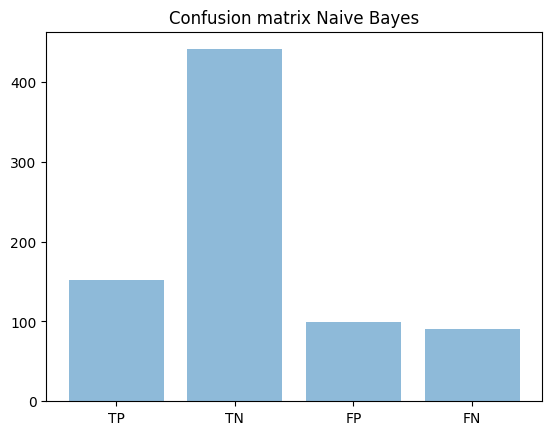

In [0]:
printInfo(prednoignore, testingFrame_classifiers, 'Naive Bayes')

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

target_names = ['not a definition', 'is a definition']

forest = LogisticRegression().fit( trainingFeatureVecs, trainingFrame_classifiers)

result = forest.predict( testingFeatureVecs )

print(classification_report(testingFrame_classifiers, result, target_names=target_names))
print('\n\ntotal f1 score', f1_score(testingFrame_classifiers, result, average='binary'))
print('total accuracy', accuracy_score(testingFrame_classifiers, result), '\n\n')

printInfo(result, testingFrame_classifiers, 'Logistic Regression')

In [0]:
classifier_model = KNeighborsClassifier(n_neighbors=20)

clf = classifier_model.fit( trainingFeatureVecs, trainingFrame_classifiers )

result = clf.predict( testingFeatureVecs )


print(classification_report(testingFrame_classifiers, result, target_names=target_names))
print('\n\ntotal f1 score', f1_score(testingFrame_classifiers, result, average='binary'))
print('total accuracy', accuracy_score(testingFrame_classifiers, result), '\n\n')

printInfo(result, testingFrame_classifiers, 'K neighbours')

In [0]:

classifier_model = DecisionTreeClassifier()

clf = classifier_model.fit( trainingFeatureVecs, trainingFrame_classifiers )

result = clf.predict( testingFeatureVecs )

print(classification_report(testingFrame_classifiers, result, target_names=target_names))
print('\n\ntotal f1 score', f1_score(testingFrame_classifiers, result, average='binary'))
print('total accuracy', accuracy_score(testingFrame_classifiers, result), '\n\n')


printInfo(result, testingFrame_classifiers, 'Decision tree')

In [0]:
from sklearn.ensemble import RandomForestClassifier
classifier_model = RandomForestClassifier()

clf = classifier_model.fit( trainingFeatureVecs, trainingFrame_classifiers)

result = clf.predict( testingFeatureVecs )

print(classification_report(testingFrame_classifiers, result, target_names=target_names))
print('\n\ntotal f1 score', f1_score(testingFrame_classifiers, result, average='binary'))
print('total accuracy', accuracy_score(testingFrame_classifiers, result), '\n\n')


printInfo(result, testingFrame_classifiers, 'Random forest')

In [0]:
# from sklearn.neural_network import MLPClassifier

# clf = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=2000, alpha=0.0001,
#                      solver='sgd',  verbose=True, random_state=21,tol=0.00001)

# clf.fit(trainingFeatureVecs, trainingFrame_classifiers)

# result = clf.predict( testingFeatureVecs )
# print(f1_score(testingFrame_classifiers, result, average='binary'))
# print(accuracy_score(testingFrame_classifiers, result))
# printInfo(result, testingFrame_classifiers, 'MLP')

In [0]:
mnbnoignore=LogisticRegression()
mnbnoignore.fit(training_cvnoignore,trainingFrame_classifiers)
testing_cvnoignore=cvnoignore.transform(testingFrame_text)
prednoignore=mnbnoignore.predict(testing_cvnoignore)
print(accuracy_score(testingFrame_classifiers, prednoignore))
print(f1_score(testingFrame_classifiers,prednoignore,average='binary'))
print(classification_report(testingFrame_classifiers, prednoignore, target_names=target_names))
print('\n\ntotal f1 score', f1_score(testingFrame_classifiers, prednoignore, average='binary'))
print('total accuracy', accuracy_score(testingFrame_classifiers, prednoignore), '\n\n')
printInfo(prednoignore, testingFrame_classifiers, 'logistic regression')

In [0]:
mnbnoignore=DecisionTreeClassifier()
mnbnoignore.fit(training_cvnoignore,trainingFrame_classifiers)
testing_cvnoignore=cvnoignore.transform(testingFrame_text)
prednoignore=mnbnoignore.predict(testing_cvnoignore)
print(accuracy_score(testingFrame_classifiers, prednoignore))
print(f1_score(testingFrame_classifiers,prednoignore,average='binary'))
print(classification_report(testingFrame_classifiers, prednoignore, target_names=target_names))
print('\n\ntotal f1 score', f1_score(testingFrame_classifiers, prednoignore, average='binary'))
print('total accuracy', accuracy_score(testingFrame_classifiers, prednoignore), '\n\n')
printInfo(prednoignore, testingFrame_classifiers, 'Decision tree')

In [0]:
mnbnoignore=RandomForestClassifier()
mnbnoignore.fit(training_cvnoignore,trainingFrame_classifiers)
testing_cvnoignore=cvnoignore.transform(testingFrame_text)
prednoignore=mnbnoignore.predict(testing_cvnoignore)
print(accuracy_score(testingFrame_classifiers, prednoignore))
print(f1_score(testingFrame_classifiers,prednoignore,average='binary'))
print(classification_report(testingFrame_classifiers, prednoignore, target_names=target_names))
print('\n\ntotal f1 score', f1_score(testingFrame_classifiers, prednoignore, average='binary'))
print('total accuracy', accuracy_score(testingFrame_classifiers, prednoignore), '\n\n')
printInfo(prednoignore, testingFrame_classifiers, 'random forest')
print(metrics.confusion_matrix(testingFrame_classifiers, prednoignore))

In [0]:
mnbnoignore=KNeighborsClassifier(n_neighbors=20)
mnbnoignore.fit(training_cvnoignore,trainingFrame_classifiers)
testing_cvnoignore=cvnoignore.transform(testingFrame_text)
prednoignore=mnbnoignore.predict(testing_cvnoignore)
print(accuracy_score(testingFrame_classifiers, prednoignore))
print(f1_score(testingFrame_classifiers,prednoignore,average='binary'))
print(classification_report(testingFrame_classifiers, prednoignore, target_names=target_names))
print('\n\ntotal f1 score', f1_score(testingFrame_classifiers, prednoignore, average='binary'))
print('total accuracy', accuracy_score(testingFrame_classifiers, prednoignore), '\n\n')
printInfo(prednoignore, testingFrame_classifiers, 'knn')

In [0]:
# f1_score(testingFrame_classifiers, result, average='binary')
len(testingFeatureVecs)

In [0]:
# print(testingFeatureVecs)
# print(trainingFeatureVecs)
# #print(result.shape)
# print(testingFrame_classifiers)

In [0]:
# !wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [0]:
# import gensim
# model = gensim.models.KeyedVectors.load_word2vec_format('/root/input/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [0]:
def printMoreInfo(df):
    pos = 0
    neg = 0
    psize = 0
    nsize = 0
    for i, sent in enumerate(df['text']):
        if df['classifier'][i] == 1:
            pos += len(sent.split())
            psize += 1
        else:
            neg += len(sent.split())
            nsize += 1
    
    print('Average number of words in a definition is ' , pos // psize)
    print('Average number of words in rest is ' , neg // nsize)

# printMoreInfo(trainingFrame)

In [0]:
# graph most frequent 100 words
vocab = list(model.wv.index2entity[:100])
X = model[vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos)

plt.show()

In [0]:
# from gensim.test.utils import common_texts
# from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# # documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)]
# documents = [TaggedDocument(text.split(), [trainingFrame_classifiers[i]]) for i, text in enumerate(trainingFrame['text'])]
# model = Doc2Vec(documents, vector_size=300, window=5, min_count=1, workers=4)

In [0]:
# model.train(documents=documents, total_examples=len(documents), epochs=10)

In [0]:
# trainingFeatureVecs = [model.infer_vector(sent.split()) for sent in trainingFrame_text]

In [0]:
# testingFeatureVecs = [model.infer_vector(sent.split()) for sent in testingFrame_text]

In [0]:
# from gensim.models import FastText
# model = FastText(size=4, window=5, min_count=1, sentences=sentences, iter=10)


In [0]:
# import numpy as np
# import pandas as pd

# from sklearn.preprocessing import LabelBinarizer
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
# from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

# import matplotlib.pyplot as plt
# plt.style.use("ggplot")

# clf = RandomForestClassifier(n_jobs=-1)

# param_grid = {
#     # 'min_samples_split': [3, 5, 10], 
#     'n_estimators' : [100, 300],
#     'max_depth': [3, 5, 15, 25],
#     # 'max_features': [3, 5, 10, 20]
# }

# scorers = {
#     'f1_score': make_scorer(f1_score),
#     'accuracy_score': make_scorer(accuracy_score)
# }

# def grid_search_wrapper(refit_score='f1_score'):
#     """
#     fits a GridSearchCV classifier using refit_score for optimization
#     prints classifier performance metrics
#     """
#     skf = StratifiedKFold(n_splits=10)
#     grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
#                            cv=skf, return_train_score=True, n_jobs=-1)
    
#     grid_search.fit(trainingFeatureVecs, trainingFrame_classifiers)

#     # make the predictions
#     y_pred = grid_search.predict(validationFeatureVecs)

#     print('Best params for {}'.format(refit_score))
#     print(grid_search.best_params_)

#     # confusion matrix on the test data.
#     print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
#     print(pd.DataFrame(confusion_matrix(y_test, y_pred),
#                  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
#     return grid_search


# grid_search_clf = grid_search_wrapper()